In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt

train_ds, test_ds = tfds.load('genomics_ood', split="train[0:100000]", "test[0:1000]", as_supervised=True)


def string_to_usable(string_tensor):
    dict = {'A': '0', 'C': '1', 'G': '2', 'T': '3'}
    for key in dict.keys():
        string_tensor = tf.strings.regex_replace(string_tensor, key, dict[key])
    split = tf.strings.bytes_split(string_tensor)
    labels = tf.cast(tf.strings.to_number(split), tf.uint8)
    onehot = tf.one_hot(labels, 4)
    onehot = tf.reshape(onehot, (-1,))
    return onehot




In [ ]:
def prepare_data(genomics_ood):
    # #convert data from uint8 to float32
    genomics_ood = genomics_ood.map(lambda seq, label: (string_to_usable(seq), tf.one_hot(label, 10)))
    # cache this progress in memory, as there is no need to redo it; it is deterministic after all
    genomics_ood = genomics_ood.cache()
    # shuffle, batch, prefetch
    genomics_ood = genomics_ood.shuffle(1000)
    genomics_ood = genomics_ood.batch(32)
    genomics_ood = genomics_ood.prefetch(20)
    # return preprocessed dataset
    return genomics_ood


train_ds = train_ds.apply(prepare_data)
test_ds = test_ds.apply(prepare_data)


# Custom Model
class MyModel(tf.keras.Model):
    
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense1 = SimpleDense(256)
        self.dense2 = SimpleDense(256)
        self.out    = SimpleDense(10)

    # @tf.function
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.out(x)
        return x


# Custom Layer
class SimpleDense(tf.keras.layers.Layer):

    def __init__(self, units=8):
        super(SimpleDense, self).__init__()
        self.units = units  # how many neurons
        self.activation = tf.nn.softmax  # what activation function

    def build(self, input_shape): 
        self.w = self.add_weight(shape=(input_shape[-1], self.units),  # add_weight supplied by Layers
                               initializer='random_normal',  # shape(input, output) initialize with normal distribution
                               trainable=True)
        self.b = self.add_weight(shape=(self.units,),  # since every weight gets a bias, number == no of units
                               initializer='random_normal',
                               trainable=True)
    def call(self, inputs): 
        x = tf.matmul(inputs, self.w) + self.b  # input multiplied with weights, add a bias -> RETURNS drive
        x = self.activation(x)  # apply activation function on drive
        return x



In [ ]:
def train_step(model, input, target, loss_function, optimizer):
    # loss_object and optimizer_object are instances of respective tensorflow classes
    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss


def test(model, test_data, loss_function):
    # test over complete test data
    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (input, target) in test_data:
        prediction = model(input)
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        sample_test_accuracy = np.mean(sample_test_accuracy)
        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

    test_loss = tf.reduce_mean(test_loss_aggregator)
    test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

    return test_loss, test_accuracy




In [ ]:
# For showcasing we only use a subset of the training and test data (generally use all of the available data!)
train_dataset = train_ds
test_dataset = test_ds

# Hyperparameters
num_epochs = 10
learning_rate = 0.3

# Initialize the model.
model = MyModel()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

# testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

# check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

    # training (and checking in with training)
    epoch_loss_agg = []
    for input, target in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)

    # track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    # testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)


IndexError: ignored

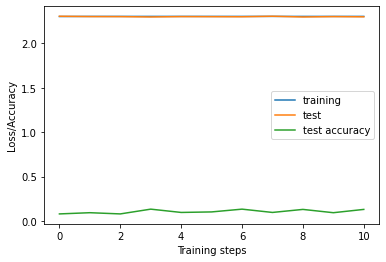

In [ ]:

# Visualize accuracy and loss for training and test data.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Loss/Accuracy")
plt.legend((line1, line2, line3), ("training", "test", "test accuracy"))
plt.show()